# 유사도 높은 콘텐츠 추천 프로그램 
- munpia_novel_data 사용

# 데이터 형태 확인

In [2]:
import pandas as pd

df = pd.read_csv("munpia_novel_data.csv", encoding ="UTF-8-SIG")

df.head()

,id,title,author,intro,tags,genre,series_count,view_count,recommend_count,link
0,0,선독점 조선에는 쿠데타가 필요해요,앙금고라니,제국주의에 조선이 살아남기 위해선 내가 군부를 장악해야 한다.,"현대판타지,대체역사,빙의,전쟁,군인,무인,대한제국,조선,한국사","대체역사, 전쟁·밀리터리",794 회,"2,105,565","118,861",https://novel.munpia.com/372155
1,1,선독점 이세계 산업역군 네크로맨서,벼루입니다,지구에서는 과로사로 죽었고 이세계에서는 산업재해로 죽었다.\n세번째 삶은 사령술로 ...,"판타지,퓨전","판타지, 퓨전",200 회,"775,727","21,482",https://novel.munpia.com/397434
2,2,선독점 놀고먹고 싶은 회장님,현우001,재벌가에서 태어났다. 골치아픈 회장님보다 강남 건물 하나 받아서 놀고 먹는 도련님이...,"경영,재벌,천재,착각,투자","현대판타지, 퓨전",176 회,"1,930,642","41,559",https://novel.munpia.com/412149
3,3,선독점 신화급 창고를 얻었다!,앤비즈,"[레벨 1,635,256,739 헌터의 유산] 을 얻었습니다.\n뭐지? 버근가?","판타지,현대판타지,게임시스템,사이다,헌터,탑등반물","판타지, 현대판타지",173 회,"748,404","15,193",https://novel.munpia.com/412352
4,4,선독점 초대 콧수염 대마왕이 되었다,리첼렌,"그래서 나, 오토 폰 비스마르크는 독일 민족의 황제가 되기로 했다.","대체역사,빙의,군주,세계사","대체역사, 판타지",219 회,"1,027,823","69,262",https://novel.munpia.com/399859


In [3]:
import chardet

with open('munpia_novel_data.csv', 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

df = pd.read_csv("munpia_novel_data.csv", encoding=encoding)
print(result)

{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}


In [4]:
df.columns

Index(['id', 'title', 'author', 'intro', 'tags', 'genre', 'series_count',
       'view_count', 'recommend_count', 'link'],
      dtype='object')

In [5]:
df.index

RangeIndex(start=0, stop=8366, step=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8366 entries, 0 to 8365
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               8366 non-null   int64 
 1   title            8366 non-null   object
 2   author           8366 non-null   object
 3   intro            8366 non-null   object
 4   tags             2801 non-null   object
 5   genre            8366 non-null   object
 6   series_count     8366 non-null   object
 7   view_count       8366 non-null   object
 8   recommend_count  8366 non-null   object
 9   link             8366 non-null   object
dtypes: int64(1), object(9)
memory usage: 653.7+ KB


# 데이터 유사성 확인 중요도 결정

- id           = 작품 고유 번호 중요도 낮음

- title        = 유사도에 높은 관여를 하는 오브젝트로 결정

- author       = 유사도에 적은 관여를 하는  오브젝트로 결정

- intro        = 유사도에 높은 관여를 하는 오브젝트로 결정

- tags         = 유사도에 높은 관여를 하는 오브젝트로 결정

- genre        = 유사도에 높은 관여를 하는 오브젝트로 결정

- series_count = 유사도에 적은 관여를 함.

- view_count   = 유사도와 적은 관여를 함.

- recommend_count = 유사도와 관련이 높은 항목

- link         = 유사도와 관련 없음 

In [7]:
# 사용 모듈

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed
from sklearn.neighbors import NearestNeighbors



# 유사도 확인 프로그램 1차
- Cosine Similarity 기반 모델   

In [8]:
# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거

# 결측치 제거
data.dropna(subset=['intro'], inplace=True)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(data['intro'])

# Cosine Similarity 계산
cosine_sim = cosine_similarity(tfidf_matrix)

# 추천 함수 정의
def recommend_webtoon(title, num_recommendations=10):
    # 입력된 제목의 인덱스 찾기
    if title not in data['title'].values:
        print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
        return
    
    idx = data.index[data['title'] == title][0]
    
    # 해당 제목과 다른 웹툰들 간의 유사도 추출
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # 결과 출력
    print(f"'{title}'와(과) 유사한 웹툰 추천 결과:")
    for i in range(1, num_recommendations + 1):
        similar_idx = sim_scores[i][0]
        similar_title = data.iloc[similar_idx]['title']
        similarity_score = sim_scores[i][1]
        print(f"{i}. {similar_title} (유사도: {similarity_score:.2f})")

# 테스트
title_to_recommend = input("추천받고 싶은 웹툰의 제목을 입력하세요: ")
recommend_webtoon(title_to_recommend)


'선독점 전지적 독자 시점'와(과) 유사한 웹툰 추천 결과:
1. 선독점 나 혼자만 강화술사 (유사도: 0.57)
2. 선독점 코딩의 신 IT재벌 되다 (유사도: 0.55)
3. 선독점 스킬 줍는 천재 기사 (유사도: 0.54)
4. 선독점 미친 소드마스터들의 구원자 (유사도: 0.53)
5. 선독점 대마도사 서자는 전생 플레이어 (유사도: 0.52)
6. 선독점 나 혼자 게이트 속 세상을 알고 있다. (유사도: 0.50)
7. 선독점 시스템 에러로 종족초월 (유사도: 0.45)
8. 선독점 실전된 무공으로 먼치킨 (유사도: 0.44)
9. 이면 세계 - 멸망의 날 (유사도: 0.40)
10. 선독점 다차원의 강령술사 (유사도: 0.40)


# 유사도 확인 프로그램 코드 작성 1차
- TF-idf와 KNN 모델 사용    

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거

# 결측치 제거
data.dropna(subset=['intro'], inplace=True)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(data['intro'])

# KNN 모델 학습
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(tfidf_matrix)

# 추천 함수 정의
def recommend_webtoon(title, num_recommendations=10):
    # 입력된 제목의 인덱스 찾기
    if title not in data['title'].values:
        print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
        return
    
    idx = data.index[data['title'] == title][0]
    tfidf_vector = tfidf_matrix[idx]
    
    # 유사한 웹툰 찾기
    distances, indices = knn_model.kneighbors(tfidf_vector, n_neighbors=num_recommendations + 1)
    
    # 결과 출력
    print(f"'{title}'와(과) 유사한 웹툰 추천 결과:")
    for i in range(1, len(indices.flatten())):
        similar_idx = indices.flatten()[i]
        similar_title = data.iloc[similar_idx]['title']
        similarity_score = 1 - distances.flatten()[i]
        print(f"{i}. {similar_title} (유사도: {similarity_score:.2f})")

# 테스트
title_to_recommend = input("추천받고 싶은 웹툰의 제목을 입력하세요: ")
recommend_webtoon(title_to_recommend)

# 설명: 사용자가 추천받고 싶은 웹툰의 제목을 입력하면, 해당 웹툰과 유사한 다른 웹툰들을 추천받을 수 있습니다.
# TF-IDF로 작품의 소개(intro) 텍스트를 벡터화하고 KNN을 이용해 가장 유사한 웹툰을 찾는 방식입니다.


'선독점 전지적 독자 시점'와(과) 유사한 웹툰 추천 결과:
1. 선독점 나 혼자만 강화술사 (유사도: 0.57)
2. 선독점 코딩의 신 IT재벌 되다 (유사도: 0.55)
3. 선독점 스킬 줍는 천재 기사 (유사도: 0.54)
4. 선독점 미친 소드마스터들의 구원자 (유사도: 0.53)
5. 선독점 대마도사 서자는 전생 플레이어 (유사도: 0.52)
6. 선독점 나 혼자 게이트 속 세상을 알고 있다. (유사도: 0.50)
7. 선독점 시스템 에러로 종족초월 (유사도: 0.45)
8. 선독점 실전된 무공으로 먼치킨 (유사도: 0.44)
9. 이면 세계 - 멸망의 날 (유사도: 0.40)
10. 선독점 다차원의 강령술사 (유사도: 0.40)


# 목록별 가중치 설정    

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.sparse import hstack

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거

# 결측치 제거
data.dropna(subset=['intro'], inplace=True)

# 가중치 설정 (예: title: 0.2, author: 0.1, intro: 0.5, tags: 0.1, genre: 0.1)
weight_title = 0.1
weight_author = 0.1
weight_intro = 0.3
weight_tags = 0.3
weight_genre = 0.2

# 각 컬럼에 대해 TF-IDF 벡터화
vectorizer_title = TfidfVectorizer(stop_words='english', max_features=500)
vectorizer_author = TfidfVectorizer(stop_words='english', max_features=500)
vectorizer_intro = TfidfVectorizer(stop_words='english', max_features=3000)
vectorizer_tags = TfidfVectorizer(stop_words='english', max_features=3000)
vectorizer_genre = TfidfVectorizer(stop_words='english', max_features=2000)

tfidf_title = vectorizer_title.fit_transform(data['title']) * weight_title
tfidf_author = vectorizer_author.fit_transform(data['author'].fillna('')) * weight_author
tfidf_intro = vectorizer_intro.fit_transform(data['intro']) * weight_intro
tfidf_tags = vectorizer_tags.fit_transform(data['tags'].fillna('')) * weight_tags
tfidf_genre = vectorizer_genre.fit_transform(data['genre'].fillna('')) * weight_genre

# 각 TF-IDF 벡터 결합
tfidf_matrix = hstack([tfidf_title, tfidf_author, tfidf_intro, tfidf_tags, tfidf_genre])

# KNN 모델 학습
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(tfidf_matrix)

# 추천 함수 정의
def recommend_webtoon(title, num_recommendations=10):
    # 입력된 제목의 인덱스 찾기
    if title not in data['title'].values:
        print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
        return
    
    idx = data.index[data['title'] == title][0]
    tfidf_vector = tfidf_matrix[idx]
    
    # 유사한 웹툰 찾기
    distances, indices = knn_model.kneighbors(tfidf_vector, n_neighbors=num_recommendations + 1)
    
    # 결과 출력
    print(f"'{title}'와(과) 유사한 웹툰 추천 결과:")
    for i in range(1, len(indices.flatten())):
        similar_idx = indices.flatten()[i]
        similar_title = data.iloc[similar_idx]['title']
        similarity_score = 1 - distances.flatten()[i]
        print(f"{i}. {similar_title} (유사도: {similarity_score:.2f})")

# 테스트
title_to_recommend = input("추천받고 싶은 웹툰의 제목을 입력하세요: ")
recommend_webtoon(title_to_recommend)

# 설명: 제목(title), 작가(author), 소개(intro), 태그(tags), 장르(genre)별로 가중치를 적용하여 유사도를 계산합니다.
# 이를 통해 중요한 요소에 가중치를 반영해 더욱 정교한 추천 결과를 제공합니다.


'' 제목의 웹툰을 찾을 수 없습니다.


- 가중치 변경시 유사도가 올라감. 현재 최적 가중치 
- weight_title = 0.1
- weight_author = 0.1
- weight_intro = 0.3
- weight_tags = 0.3
- weight_genre = 0.2

# TF-idf에 한국어 불용어 적용 안된 것을 확인 불용어 적용    

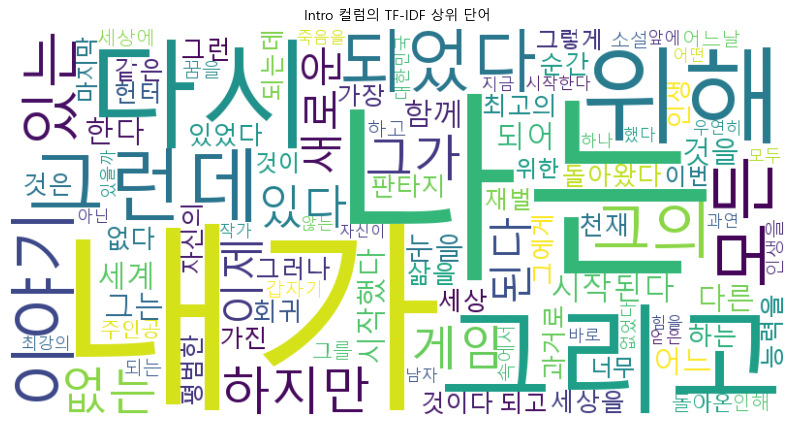

In [11]:
# 불용어 적용을 위한 시각화
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.font_manager as fm

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# intro 컬럼에 대한 TF-IDF 계산
vectorizer = TfidfVectorizer(max_features=100)  # 상위 100개 단어만 추출
tfidf_matrix = vectorizer.fit_transform(data['intro'].fillna(''))

# TF-IDF 결과를 데이터프레임으로 변환
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# 각 단어의 전체 TF-IDF 합계 계산
tfidf_sums = tfidf_df.sum(axis=0).sort_values(ascending=False)

# 한국어 폰트 설정
# malgun.ttf (맑은 고딕) 폰트를 사용하는 예제입니다. 해당 폰트 경로로 설정하세요.
font_path = 'C:\Windows\Fonts\malgun.ttf'  # 시스템에 설치된 폰트 경로 확인 후 설정

# 시각화: WordCloud 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(tfidf_sums)

# WordCloud 결과 출력
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Intro 컬럼의 TF-IDF 상위 단어', fontproperties=fm.FontProperties(fname=font_path))
plt.show()


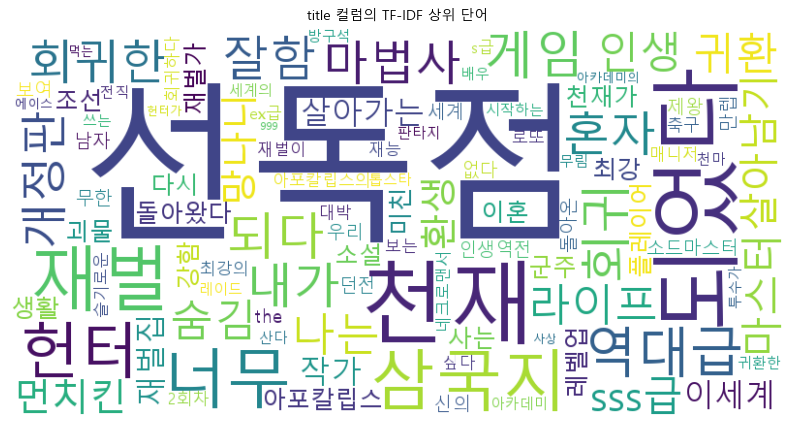

In [12]:
# 불용어 적용을 위한 시각화
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.font_manager as fm

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# intro 컬럼에 대한 TF-IDF 계산
vectorizer = TfidfVectorizer(max_features=100)  # 상위 100개 단어만 추출
tfidf_matrix = vectorizer.fit_transform(data['title'].fillna(''))

# TF-IDF 결과를 데이터프레임으로 변환
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# 각 단어의 전체 TF-IDF 합계 계산
tfidf_sums = tfidf_df.sum(axis=0).sort_values(ascending=False)

# 한국어 폰트 설정
# malgun.ttf (맑은 고딕) 폰트를 사용하는 예제입니다. 해당 폰트 경로로 설정하세요.
font_path = 'C:\Windows\Fonts\malgun.ttf'  # 시스템에 설치된 폰트 경로 확인 후 설정

# 시각화: WordCloud 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(tfidf_sums)

# WordCloud 결과 출력
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('title 컬럼의 TF-IDF 상위 단어', fontproperties=fm.FontProperties(fname=font_path))
plt.show()


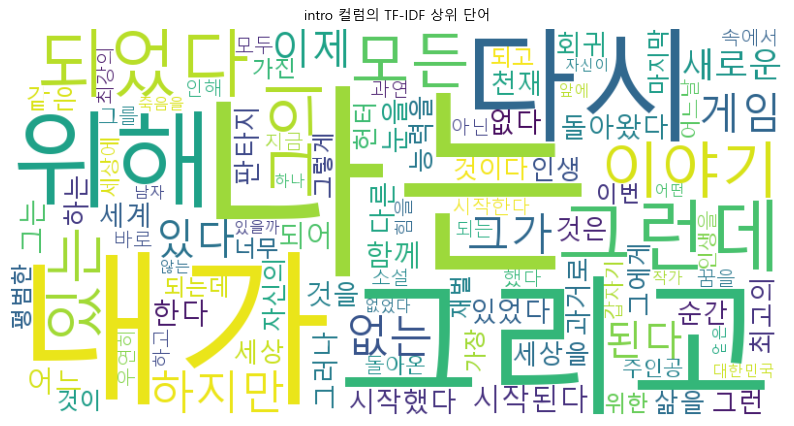

In [13]:
# 불용어 적용을 위한 시각화
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.font_manager as fm

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# intro 컬럼에 대한 TF-IDF 계산
vectorizer = TfidfVectorizer(max_features=100)  # 상위 100개 단어만 추출
tfidf_matrix = vectorizer.fit_transform(data['intro'].fillna(''))

# TF-IDF 결과를 데이터프레임으로 변환
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# 각 단어의 전체 TF-IDF 합계 계산
tfidf_sums = tfidf_df.sum(axis=0).sort_values(ascending=False)

# 한국어 폰트 설정
# malgun.ttf (맑은 고딕) 폰트를 사용하는 예제입니다. 해당 폰트 경로로 설정하세요.
font_path = 'C:\Windows\Fonts\malgun.ttf'  # 시스템에 설치된 폰트 경로 확인 후 설정

# 시각화: WordCloud 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(tfidf_sums)

# WordCloud 결과 출력
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('intro 컬럼의 TF-IDF 상위 단어', fontproperties=fm.FontProperties(fname=font_path))
plt.show()


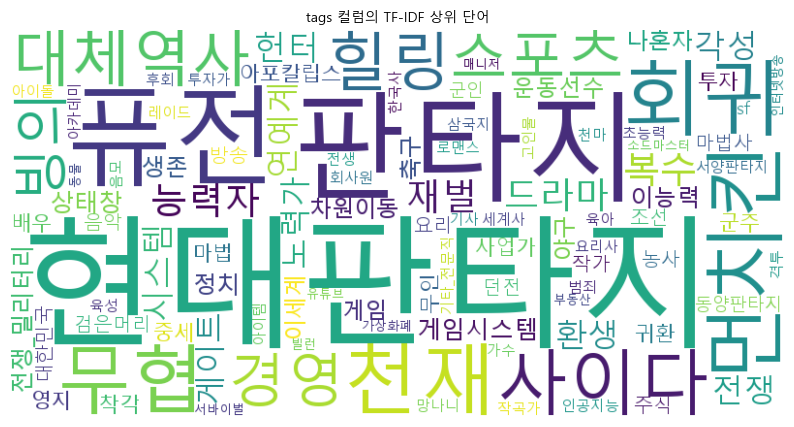

In [14]:
# 불용어 적용을 위한 시각화
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.font_manager as fm

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# intro 컬럼에 대한 TF-IDF 계산
vectorizer = TfidfVectorizer(max_features=100)  # 상위 100개 단어만 추출
tfidf_matrix = vectorizer.fit_transform(data['tags'].fillna(''))

# TF-IDF 결과를 데이터프레임으로 변환
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# 각 단어의 전체 TF-IDF 합계 계산
tfidf_sums = tfidf_df.sum(axis=0).sort_values(ascending=False)

# 한국어 폰트 설정
# malgun.ttf (맑은 고딕) 폰트를 사용하는 예제입니다. 해당 폰트 경로로 설정하세요.
font_path = 'C:\Windows\Fonts\malgun.ttf'  # 시스템에 설치된 폰트 경로 확인 후 설정

# 시각화: WordCloud 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(tfidf_sums)

# WordCloud 결과 출력
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('tags 컬럼의 TF-IDF 상위 단어', fontproperties=fm.FontProperties(fname=font_path))
plt.show()


In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.sparse import hstack

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거

# 결측치 제거
data.dropna(subset=['intro'], inplace=True)

# 한국어 불용어 리스트를 리스트로 설정
stop_words = ["를", "의", "선", "독점", "나는", "내가", "그리고", "그런데","위해","되어", "그의", "그는", "되었다", "있었다", "있다", "없다",
              "선독점", "독점작", "그녀","위해"]

# 가중치 설정 (예: title: 0.1, author: 0.1, intro: 0.3, tags: 0.3, genre: 0.2) 여러번 시도해서 가장 높은 유사도를 가진 가중치
weight_title = 0.1
weight_author = 0.1
weight_intro = 0.3
weight_tags = 0.3
weight_genre = 0.2

# 각 컬럼에 대해 TF-IDF 벡터화
vectorizer_title = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_author = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_intro = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_tags = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_genre = TfidfVectorizer(stop_words=stop_words, max_features=2000)

tfidf_title = vectorizer_title.fit_transform(data['title']) * weight_title
tfidf_author = vectorizer_author.fit_transform(data['author'].fillna('')) * weight_author
tfidf_intro = vectorizer_intro.fit_transform(data['intro']) * weight_intro
tfidf_tags = vectorizer_tags.fit_transform(data['tags'].fillna('')) * weight_tags
tfidf_genre = vectorizer_genre.fit_transform(data['genre'].fillna('')) * weight_genre

# 각 TF-IDF 벡터 결합
tfidf_matrix = hstack([tfidf_title, tfidf_author, tfidf_intro, tfidf_tags, tfidf_genre])

# KNN 모델 학습
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(tfidf_matrix)

# 추천 함수 정의
def recommend_webtoon(title, num_recommendations=10):
    # 입력된 제목의 인덱스 찾기
    if title not in data['title'].values:
        print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
        return
    
    idx = data.index[data['title'] == title][0]
    tfidf_vector = tfidf_matrix[idx]
    
    # 유사한 웹툰 찾기
    distances, indices = knn_model.kneighbors(tfidf_vector, n_neighbors=num_recommendations + 1)
    
    # 결과 출력
    print(f"'{title}'와(과) 유사한 웹툰 추천 결과:")
    for i in range(1, len(indices.flatten())):
        similar_idx = indices.flatten()[i]
        similar_title = data.iloc[similar_idx]['title']
        similarity_score = 1 - distances.flatten()[i]
        print(f"{i}. {similar_title} (유사도: {similarity_score:.2f})")

# 테스트
title_to_recommend = input("추천받고 싶은 웹툰의 제목을 입력하세요: ")
recommend_webtoon(title_to_recommend)

# 설명: 각 컬럼에 대해 불용어 리스트를 적용하여 TF-IDF 벡터화를 수행합니다.
# 제목(title), 작가(author), 소개(intro), 태그(tags), 장르(genre)별로 가중치를 적용하여 유사도를 계산합니다.


'' 제목의 웹툰을 찾을 수 없습니다.


# Z 스코어 표준화

In [1]:
import pandas as pd                        # 데이터 불러오기 및 전처리
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF 벡터화
from sklearn.neighbors import NearestNeighbors  # KNN 모델 학습 및 추천
from sklearn.preprocessing import StandardScaler  # Z-스코어 표준화
from scipy.sparse import hstack          # 희소 행렬 결합
import numpy as np                       # 배열 및 수치 계산 (필요시)


In [2]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거

# 결측치 제거
data.dropna(subset=['intro'], inplace=True)

# 한국어 불용어 리스트
stop_words = ["를", "의", "선", "독점", "나는", "내가", "그리고", "그런데","위해","되어", "그의", "그는", "되었다", "있었다", "있다", "없다",
              "선독점", "독점작", "그녀","위해"]

# 가중치 설정
weight_title = 0.1
weight_author = 0.1
weight_intro = 0.3
weight_tags = 0.3
weight_genre = 0.2

# 각 컬럼에 대해 TF-IDF 벡터화
vectorizer_title = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_author = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_intro = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_tags = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_genre = TfidfVectorizer(stop_words=stop_words, max_features=2000)

tfidf_title = vectorizer_title.fit_transform(data['title']) * weight_title
tfidf_author = vectorizer_author.fit_transform(data['author'].fillna('')) * weight_author
tfidf_intro = vectorizer_intro.fit_transform(data['intro']) * weight_intro
tfidf_tags = vectorizer_tags.fit_transform(data['tags'].fillna('')) * weight_tags
tfidf_genre = vectorizer_genre.fit_transform(data['genre'].fillna('')) * weight_genre

# Z-스코어 표준화
scaler = StandardScaler(with_mean=False)  # sparse matrix에서는 with_mean=False
tfidf_title = scaler.fit_transform(tfidf_title)
tfidf_author = scaler.fit_transform(tfidf_author)
tfidf_intro = scaler.fit_transform(tfidf_intro)
tfidf_tags = scaler.fit_transform(tfidf_tags)
tfidf_genre = scaler.fit_transform(tfidf_genre)

# 각 TF-IDF 벡터 결합
tfidf_matrix = hstack([tfidf_title, tfidf_author, tfidf_intro, tfidf_tags, tfidf_genre])

# KNN 모델 학습
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(tfidf_matrix)

# 추천 함수 정의
def recommend_webtoon(title, num_recommendations=10):
    if title not in data['title'].values:
        print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
        return
    
    idx = data.index[data['title'] == title][0]
    tfidf_vector = tfidf_matrix[idx]
    
    # 유사한 웹툰 찾기
    distances, indices = knn_model.kneighbors(tfidf_vector, n_neighbors=num_recommendations + 1)
    
    # 결과 출력
    print(f"'{title}'와(과) 유사한 웹툰 추천 결과:")
    for i in range(1, len(indices.flatten())):
        similar_idx = indices.flatten()[i]
        similar_title = data.iloc[similar_idx]['title']
        similarity_score = 1 - distances.flatten()[i]
        print(f"{i}. {similar_title} (유사도: {similarity_score:.2f})")

# 테스트
title_to_recommend = input("추천받고 싶은 웹툰의 제목을 입력하세요: ")
recommend_webtoon(title_to_recommend)


'선독점 전지적 독자 시점'와(과) 유사한 웹툰 추천 결과:
1. 선독점 코딩의 신 IT재벌 되다 (유사도: 0.54)
2. 선독점 내 레벨 146,484,375 (유사도: 0.42)
3. 선독점 나 혼자만 강화술사 (유사도: 0.41)
4. 선독점 미친 소드마스터들의 구원자 (유사도: 0.39)
5. 선독점 나 혼자 게이트 속 세상을 알고 있다. (유사도: 0.39)
6. 선독점 대마도사 서자는 전생 플레이어 (유사도: 0.37)
7. 선독점 스킬 줍는 천재 기사 (유사도: 0.37)
8. 이면 세계 - 멸망의 날 (유사도: 0.37)
9. 선독점 시스템 에러로 종족초월 (유사도: 0.34)
10. 선독점 SSS급 초능력자 (유사도: 0.32)


# 여러가지 웹소설 이름 입력
- 각 입력 제목의 TF-IDF 벡터를 가져와 평균 벡터를 구하고, 이 평균 벡터와 유사한 웹툰들을 추천 목록으로 출력

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.sparse import hstack

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거

# 결측치 제거
data.dropna(subset=['intro'], inplace=True)

# 한국어 불용어 리스트를 리스트로 설정
stop_words = ["를", "의", "선", "독점", "선독점", "독점작", "이번", "들", "등", "수", "이", "부", "판", "뿐", "여자", "남자", "그", "것", "나", "그녀", "속", "시작", "내", "거", "중"]

# 가중치 설정 (예: title: 0.1, author: 0.1, intro: 0.3, tags: 0.3, genre: 0.2)
weight_title = 0.1
weight_author = 0.1
weight_intro = 0.3
weight_tags = 0.3
weight_genre = 0.2

# 각 컬럼에 대해 TF-IDF 벡터화
vectorizer_title = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_author = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_intro = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_tags = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_genre = TfidfVectorizer(stop_words=stop_words, max_features=2000)

tfidf_title = vectorizer_title.fit_transform(data['title']) * weight_title
tfidf_author = vectorizer_author.fit_transform(data['author'].fillna('')) * weight_author
tfidf_intro = vectorizer_intro.fit_transform(data['intro']) * weight_intro
tfidf_tags = vectorizer_tags.fit_transform(data['tags'].fillna('')) * weight_tags
tfidf_genre = vectorizer_genre.fit_transform(data['genre'].fillna('')) * weight_genre

# 각 TF-IDF 벡터 결합
tfidf_matrix = hstack([tfidf_title, tfidf_author, tfidf_intro, tfidf_tags, tfidf_genre])

# KNN 모델 학습
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(tfidf_matrix)

# 추천 함수 정의
def recommend_webtoons(titles, num_recommendations=10):
    indices = []
    for title in titles:
        if title not in data['title'].values:
            print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
            continue
        idx = data.index[data['title'] == title][0]
        indices.append(idx)
    
    if not indices:
        print("유효한 웹툰 제목이 없습니다.")
        return

    # 입력된 제목들의 TF-IDF 벡터 평균 계산
    tfidf_vectors = tfidf_matrix[indices]
    mean_vector = tfidf_vectors.mean(axis=0)
    mean_vector = np.asarray(mean_vector)  # np.matrix를 np.array로 변환
    
    # 유사한 웹툰 찾기
    distances, result_indices = knn_model.kneighbors(mean_vector, n_neighbors=num_recommendations + 1)
    
    # 결과 출력
    print(f"\n입력된 웹소설들과 유사한 웹소설 추천 결과:")
    for i in range(1, len(result_indices.flatten())):
        similar_idx = result_indices.flatten()[i]
        similar_title = data.iloc[similar_idx]['title']
        similarity_score = 1 - distances.flatten()[i]
        print(f"{i}. {similar_title} (유사도: {similarity_score:.2f})")

# 여러 웹툰 이름 입력받아 추천
titles_to_recommend = input("추천받고 싶은 웹소설의 제목을 쉼표로 구분하여 입력하세요: ").split(',')
titles_to_recommend = [title.strip() for title in titles_to_recommend]  # 공백 제거
recommend_webtoons(titles_to_recommend)



입력된 웹소설들과 유사한 웹소설 추천 결과:
1. 선독점 코딩의 신 IT재벌 되다 (유사도: 0.74)
2. 선독점 감독보다 영화사 대표님 (유사도: 0.55)
3. 선독점 마법천재 마술방송 (유사도: 0.55)
4. 선독점 내 아공간이 지구와 연결되어있다 (유사도: 0.52)
5. 선독점 미친 소드마스터들의 구원자 (유사도: 0.51)
6. 선독점 대마도사 서자는 전생 플레이어 (유사도: 0.51)
7. 선독점 실전된 무공으로 먼치킨 (유사도: 0.50)
8. 선독점 신이 내린 방송천재 (유사도: 0.50)
9. 선독점 천상계 지갑전사 (유사도: 0.50)
10. 선독점 돈지랄 마법사 (유사도: 0.50)


# 유사도 확인 프로그램 3차
- Sentence-BERT 모델, KNN 모델 결합

In [ ]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer
import numpy as np

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['id', 'title', 'author', 'intro', 'tags', 'genre', 'series_count', 'view_count', 'recommend_count', 'link']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거

# 결측치 제거
data.dropna(subset=['intro'], inplace=True)

# Sentence-BERT 모델 로드 및 벡터화
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(data['intro'].tolist())

# KNN 모델 학습
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(embeddings)

# 추천 함수 정의
def recommend_webtoon(title, num_recommendations=10):
    # 입력된 제목의 인덱스 찾기
    if title not in data['title'].values:
        print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
        return
    
    idx = data.index[data['title'] == title][0]
    embedding_vector = embeddings[idx].reshape(1, -1)
    
    # 유사한 웹툰 찾기
    distances, indices = knn_model.kneighbors(embedding_vector, n_neighbors=num_recommendations + 1)
    
    # 결과 출력
    print(f"'{title}'와(과) 유사한 웹툰 추천 결과:")
    for i in range(1, len(indices.flatten())):
        similar_idx = indices.flatten()[i]
        similar_title = data.iloc[similar_idx]['title']
        similar_author = data.iloc[similar_idx]['author']
        similar_genre = data.iloc[similar_idx]['genre']
        similarity_score = 1 - distances.flatten()[i]
        print(f"{i}. {similar_title} (저자: {similar_author}, 장르: {similar_genre}, 유사도: {similarity_score:.2f})")

# 테스트
title_to_recommend = input("추천받고 싶은 웹툰의 제목을 입력하세요: ")
recommend_webtoon(title_to_recommend)

# 설명: 사용자는 추천받고 싶은 웹툰의 제목을 입력하면 해당 웹툰과 유사한 다른 웹툰들을 추천받을 수 있습니다. 
# Sentence-BERT로 작품의 소개(intro) 텍스트를 벡터화하고 KNN을 이용해 가장 유사한 웹툰을 찾는 방식입니다.


- 오류 해결 안됨 실패...

# 유사도 확인 프로그램 4차  
-  Word2Vec 임베딩 기반

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거
data.dropna(subset=['intro'], inplace=True)  # 결측치 제거

# 텍스트 전처리 함수
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9가-힣\s]", "", text)  # 특수문자 제거
    return text.split()

# 텍스트 전처리 적용
data['processed_intro'] = data['intro'].apply(preprocess_text)

# Word2Vec 모델 학습
word2vec_model = Word2Vec(sentences=data['processed_intro'], vector_size=100, window=5, min_count=2, workers=4)

# 문장의 평균 벡터 계산 함수
def get_sentence_vector(words):
    # 단어가 Word2Vec 모델에 존재하면 벡터에 추가
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

# 모든 소개 텍스트에 대한 평균 벡터 계산
data['intro_vector'] = data['processed_intro'].apply(get_sentence_vector)

# 추천 함수 정의
def recommend_webtoon(title, num_recommendations=10):
    # 입력된 제목의 인덱스 찾기
    if title not in data['title'].values:
        print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
        return

    # 입력 제목의 임베딩 벡터 추출
    idx = data.index[data['title'] == title][0]
    target_vector = data.iloc[idx]['intro_vector'].reshape(1, -1)

    # 코사인 유사도 계산
    vectors = np.stack(data['intro_vector'].values)
    similarities = cosine_similarity(target_vector, vectors).flatten()
    
    # 유사도 순으로 정렬
    sim_scores = list(enumerate(similarities))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 결과 출력
    print(f"'{title}'와(과) 유사한 웹툰 추천 결과:")
    for i in range(1, num_recommendations + 1):
        similar_idx = sim_scores[i][0]
        similar_title = data.iloc[similar_idx]['title']
        similarity_score = sim_scores[i][1]
        print(f"{i}. {similar_title} (유사도: {similarity_score:.2f})")

# 테스트
title_to_recommend = input("추천받고 싶은 웹툰의 제목을 입력하세요: ")
recommend_webtoon(title_to_recommend)


C:\Users\신형우\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\paramiko\pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\신형우\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\paramiko\transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


'선독점 전지적 독자 시점'와(과) 유사한 웹툰 추천 결과:
1. 선독점 나 혼자 게이트 속 세상을 알고 있다. (유사도: 1.00)
2. 제일후 (유사도: 1.00)
3. 선독점 무명래퍼 힙합영재로 회귀하다 (유사도: 1.00)
4. 뉴트럴 (유사도: 1.00)
5. 선독점 백발검귀(白髮劍鬼) (유사도: 1.00)
6. 남자 주인공이 파산이라니요 (유사도: 1.00)
7. 풍신 [연재] (유사도: 1.00)
8. 선독점 실전된 무공으로 먼치킨 (유사도: 1.00)
9. 아르카나 마법도서관 (유사도: 1.00)
10. 선독점 삼위일체 (유사도: 1.00)


- 자료가 한글 기반이라 문제 발생 수정
- konlpy 라이브러리 사용    

In [7]:
import pandas as pd
from gensim.models import Word2Vec
from konlpy.tag import Okt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거
data.dropna(subset=['intro'], inplace=True)  # 결측치 제거

# 형태소 분석기 설정
okt = Okt()

# 텍스트 전처리 함수
def preprocess_text(text):
    tokens = [word for word, pos in okt.pos(text) if pos in ['Noun', 'Adjective', 'Verb']]
    return tokens

# 텍스트 전처리 적용
data['processed_intro'] = data['intro'].apply(preprocess_text)

# Word2Vec 모델 학습
word2vec_model = Word2Vec(sentences=data['processed_intro'], vector_size=100, window=5, min_count=1, workers=4)


# 문장의 평균 벡터 계산 함수
def get_sentence_vector(words):
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

# 모든 소개 텍스트에 대한 평균 벡터 계산
data['intro_vector'] = data['processed_intro'].apply(get_sentence_vector)

# 추천 함수 정의
def recommend_webtoon(title, num_recommendations=10):
    if title not in data['title'].values:
        print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
        return

    idx = data.index[data['title'] == title][0]
    target_vector = data.iloc[idx]['intro_vector'].reshape(1, -1)

    # 코사인 유사도 계산
    vectors = np.stack(data['intro_vector'].values)
    similarities = cosine_similarity(target_vector, vectors).flatten()
    
    # 유사도 순으로 정렬
    sim_scores = list(enumerate(similarities))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 결과 출력
    print(f"'{title}'와(과) 유사한 웹툰 추천 결과:")
    for i in range(1, num_recommendations + 1):
        similar_idx = sim_scores[i][0]
        similar_title = data.iloc[similar_idx]['title']
        similarity_score = sim_scores[i][1]
        print(f"{i}. {similar_title} (유사도: {similarity_score:.2f})")

# 테스트
title_to_recommend = input("추천받고 싶은 웹툰의 제목을 입력하세요: ")
recommend_webtoon(title_to_recommend)


'선독점 전지적 독자 시점'와(과) 유사한 웹툰 추천 결과:
1. 선독점 나 혼자 게이트 속 세상을 알고 있다. (유사도: 1.00)
2. 어나더 라이프 (유사도: 1.00)
3. 선독점 돈 쓸어담는 천재 작가 (유사도: 1.00)
4. 선독점 하남자의 현금 사용법 (유사도: 1.00)
5. 선독점 운빨 확률 사냥꾼 (유사도: 1.00)
6. 콘크리트 펀치 (유사도: 1.00)
7. 나 혼자 천재 DNA (유사도: 1.00)
8. 선독점 나태한 천재 스트라이커 (유사도: 1.00)
9. 선독점 불멸무적자 (유사도: 1.00)
10. 선독점 고삐 풀린 용사님! (유사도: 1.00)


# 기타 gpt 에게 추천 받은 모델들

# 시암 네트워크 모델 기반
- 시간이 굉장히 오래 걸림

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 데이터 로드 및 전처리
data = pd.read_csv('munpia_novel_data.csv')
data = data[['title', 'intro', 'genre']].drop_duplicates(subset=['title']).dropna(subset=['intro'])

# 텍스트 토크나이저 설정 및 패딩
tokenizer = Tokenizer(num_words=5000)  # 단어의 수 제한
tokenizer.fit_on_texts(data['intro'])
sequences = tokenizer.texts_to_sequences(data['intro'])
intro_padded = pad_sequences(sequences, maxlen=300)  # 최대 길이 설정

# 2. 유사한 쌍과 비유사한 쌍 만들기 (장르가 같은 경우 유사, 다른 경우 비유사로 설정)
def create_pairs(data, intro_padded):
    pairs = []
    labels = []
    for idx1, row1 in data.iterrows():
        for idx2, row2 in data.iterrows():
            if idx1 < idx2:  # 중복 방지
                is_similar = int(row1['genre'] == row2['genre'])
                pairs.append((intro_padded[idx1], intro_padded[idx2]))
                labels.append(is_similar)
    return np.array(pairs), np.array(labels)

pairs, labels = create_pairs(data, intro_padded)
train_pairs, test_pairs, train_labels, test_labels = train_test_split(pairs, labels, test_size=0.2)

# 3. 시암 네트워크 모델 정의
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = LSTM(128, return_sequences=False)(input)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

input_shape = (300,)  # 텍스트 임베딩의 길이
base_network = create_base_network(input_shape)

# 두 개의 입력과 거리를 계산
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

# 유클리드 거리 계산
distance = Lambda(lambda embeddings: K.sqrt(K.sum(K.square(embeddings[0] - embeddings[1]), axis=-1)))([processed_a, processed_b])

# 시암 네트워크 정의
model = Model([input_a, input_b], distance)
model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

import random

# 데이터 일부 쌍만 생성하기 위한 함수
def create_pairs_sampled(data, intro_padded, sample_size=10000):
    pairs = []
    labels = []
    num_samples = min(len(data) * (len(data) - 1) // 2, sample_size)  # 생성할 쌍의 수 제한
    indices = list(range(len(data)))
    
    # 샘플링된 쌍 생성
    for _ in range(num_samples):
        idx1, idx2 = random.sample(indices, 2)
        is_similar = int(data.iloc[idx1]['genre'] == data.iloc[idx2]['genre'])
        pairs.append((intro_padded[idx1], intro_padded[idx2]))
        labels.append(is_similar)
    
    return np.array(pairs), np.array(labels)

# 샘플링된 쌍 생성
pairs, labels = create_pairs_sampled(data, intro_padded, sample_size=10000)
train_pairs, test_pairs, train_labels, test_labels = train_test_split(pairs, labels, test_size=0.2)

# 4. 모델 학습
model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels, batch_size=32, epochs=10,
          validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_labels))

# 5. 추천 함수 정의
def recommend_webtoon(title, data, model, intro_padded, num_recommendations=5):
    # 입력된 제목의 인덱스 찾기
    if title not in data['title'].values:
        print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
        return

    idx = data.index[data['title'] == title][0]
    target_intro = intro_padded[idx].reshape(1, -1)

    distances = []
    for i, intro in enumerate(intro_padded):
        if i != idx:  # 자신 제외
            distance = model.predict([target_intro, intro.reshape(1, -1)])
            distances.append((i, distance[0][0]))


    # 거리 기준으로 정렬하여 상위 추천
    distances = sorted(distances, key=lambda x: x[1])
    print(f"'{title}'와(과) 유사한 웹툰 추천 결과:")
    for i in range(num_recommendations):
        similar_idx = distances[i][0]
        similar_title = data.iloc[similar_idx]['title']
        print(f"{i + 1}. {similar_title} (유사도 거리: {distances[i][1]:.2f})")

# 테스트: 추천받고 싶은 웹툰의 제목 입력
title_to_recommend = input("추천받고 싶은 웹툰의 제목을 입력하세요: ")
recommend_webtoon(title_to_recommend, data, model, intro_padded)


MemoryError: Unable to allocate 78.2 GiB for an array with shape (34990795, 2, 300) and data type int32

# 임배딩 기반
- ada-002

In [ ]:
import openai
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re

# OpenAI API 키 설정
openai.api_key = ""

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거
data.dropna(subset=['intro'], inplace=True)  # 결측치 제거

# 한국어 불용어 리스트 설정
stop_words = ["를", "의", "선", "독점", "나는", "내가", "그리고", "그런데", "위해", "되어", "그의", "그는", "되었다", 
              "있었다", "있다", "없다", "선독점", "독점작", "그녀", "위해"]

# 텍스트 전처리 함수
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9가-힣\s]", "", text)  # 특수문자 제거
    for stop_word in stop_words:
        text = text.replace(stop_word, "")
    return text

# 전처리 및 모든 컬럼 통합
data['combined_text'] = (
    data['title'].apply(preprocess_text) + " " +
    data['author'].fillna('').apply(preprocess_text) + " " +
    data['intro'].apply(preprocess_text) + " " +
    data['tags'].fillna('').apply(preprocess_text) + " " +
    data['genre'].fillna('').apply(preprocess_text)
)

# OpenAI 임베딩 요청 함수
def get_embedding(text, model="text-embedding-ada-002"):
    response = openai.Embedding.create(input=text, model=model)
    return response['data'][0]['embedding']

# 모든 텍스트에 대한 임베딩 생성
print("임베딩 생성 중...")
data['embedding'] = data['combined_text'].apply(lambda x: get_embedding(x))

# 추천 함수 정의
def recommend_webtoon(title, num_recommendations=10):
    # 입력된 제목의 인덱스 찾기
    if title not in data['title'].values:
        print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
        return

    # 입력 웹툰 임베딩 가져오기
    idx = data.index[data['title'] == title][0]
    target_embedding = np.array(data.iloc[idx]['embedding']).reshape(1, -1)

    # 모든 웹툰 임베딩 벡터 가져오기
    embeddings = np.stack(data['embedding'].values)
    
    # 코사인 유사도 계산
    similarities = cosine_similarity(target_embedding, embeddings).flatten()
    
    # 유사도 순으로 정렬
    sim_scores = list(enumerate(similarities))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 결과 출력
    print(f"'{title}'와(과) 유사한 웹툰 추천 결과:")
    for i in range(1, num_recommendations + 1):
        similar_idx = sim_scores[i][0]
        similar_title = data.iloc[similar_idx]['title']
        similarity_score = sim_scores[i][1]
        print(f"{i}. {similar_title} (유사도: {similarity_score:.2f})")

# 테스트
title_to_recommend = input("추천받고 싶은 웹툰의 제목을 입력하세요: ")
recommend_webtoon(title_to_recommend)


- 가격 문제로 보류 ada-002 모델 보류 
- 허깅 페이스 모델 사용
- 허깅 페이스의 sentenceTransformer 모델

In [15]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re

# 허깅 페이스 모델 로드
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거
data.dropna(subset=['intro'], inplace=True)  # 결측치 제거

# 한국어 불용어 리스트 설정
stop_words = ["를", "의", "선", "독점", "나는", "내가", "그리고", "그런데", "위해", "되어", "그의", "그는", "되었다", 
              "있었다", "있다", "없다", "선독점", "독점작", "그녀", "위해"]

# 텍스트 전처리 함수
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9가-힣\s]", "", text)  # 특수문자 제거
    for stop_word in stop_words:
        text = text.replace(stop_word, "")
    return text

# 전처리 및 모든 컬럼 통합
data['combined_text'] = (
    data['title'].apply(preprocess_text) + " " +
    data['author'].fillna('').apply(preprocess_text) + " " +
    data['intro'].apply(preprocess_text) + " " +
    data['tags'].fillna('').apply(preprocess_text) + " " +
    data['genre'].fillna('').apply(preprocess_text)
)

# 모든 텍스트에 대한 임베딩 생성
print("임베딩 생성 중...")
data['embedding'] = data['combined_text'].apply(lambda x: model.encode(x))

# 추천 함수 정의
def recommend_webtoon(title, num_recommendations=10):
    # 입력된 제목의 인덱스 찾기
    if title not in data['title'].values:
        print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
        return

    # 입력 웹툰 임베딩 가져오기
    idx = data.index[data['title'] == title][0]
    target_embedding = np.array(data.iloc[idx]['embedding']).reshape(1, -1)

    # 모든 웹툰 임베딩 벡터 가져오기
    embeddings = np.stack(data['embedding'].values)
    
    # 코사인 유사도 계산
    similarities = cosine_similarity(target_embedding, embeddings).flatten()
    
    # 유사도 순으로 정렬
    sim_scores = list(enumerate(similarities))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 결과 출력
    print(f"'{title}'와(과) 유사한 웹툰 추천 결과:")
    for i in range(1, num_recommendations + 1):
        similar_idx = sim_scores[i][0]
        similar_title = data.iloc[similar_idx]['title']
        similarity_score = sim_scores[i][1]
        print(f"{i}. {similar_title} (유사도: {similarity_score:.2f})")

# 테스트
title_to_recommend = input("추천받고 싶은 웹툰의 제목을 입력하세요: ")
recommend_webtoon(title_to_recommend)


RuntimeError: Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

# 행렬 분해 메트릭스 모델
- TruncatedSVD 를 사용한 행렬 분해

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거

# 결측치 제거
data.dropna(subset=['intro'], inplace=True)

# 한국어 불용어 리스트를 리스트로 설정
stop_words = ["를", "의", "선", "독점", "나는", "내가", "그리고", "그런데","위해","되어", "그의", "그는", "되었다", "있었다", "있다", "없다",
              "선독점", "독점작", "그녀","위해"]

# 가중치 설정 (예: title: 0.1, author: 0.1, intro: 0.3, tags: 0.3, genre: 0.2)
weight_title = 0.1
weight_author = 0.1
weight_intro = 0.3
weight_tags = 0.3
weight_genre = 0.2

# 각 컬럼에 대해 TF-IDF 벡터화
vectorizer_title = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_author = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_intro = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_tags = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_genre = TfidfVectorizer(stop_words=stop_words, max_features=2000)

tfidf_title = vectorizer_title.fit_transform(data['title']) * weight_title
tfidf_author = vectorizer_author.fit_transform(data['author'].fillna('')) * weight_author
tfidf_intro = vectorizer_intro.fit_transform(data['intro']) * weight_intro
tfidf_tags = vectorizer_tags.fit_transform(data['tags'].fillna('')) * weight_tags
tfidf_genre = vectorizer_genre.fit_transform(data['genre'].fillna('')) * weight_genre

# 각 TF-IDF 벡터 결합
tfidf_matrix = hstack([tfidf_title, tfidf_author, tfidf_intro, tfidf_tags, tfidf_genre])

# SVD를 사용하여 차원 축소
svd = TruncatedSVD(n_components=100, random_state=42)
latent_matrix = svd.fit_transform(tfidf_matrix)

# 유사도 계산 함수
def recommend_webtoon(title, num_recommendations=10):
    # 입력된 제목의 인덱스 찾기
    if title not in data['title'].values:
        print(f"'{title}' 제목의 웹툰을 찾을 수 없습니다.")
        return
    
    idx = data.index[data['title'] == title][0]
    query_vector = latent_matrix[idx].reshape(1, -1)
    
    # 모든 웹툰 간의 코사인 유사도 계산
    similarities = cosine_similarity(query_vector, latent_matrix).flatten()
    
    # 유사도가 높은 순으로 정렬
    similar_indices = similarities.argsort()[::-1][1:num_recommendations + 1]
    
    # 결과 출력
    print(f"'{title}'와(과) 유사한 웹툰 추천 결과:")
    for i, similar_idx in enumerate(similar_indices, 1):
        similar_title = data.iloc[similar_idx]['title']
        similarity_score = similarities[similar_idx]
        print(f"{i}. {similar_title} (유사도: {similarity_score:.2f})")

# 테스트
title_to_recommend = input("추천받고 싶은 웹툰의 제목을 입력하세요: ")
recommend_webtoon(title_to_recommend)


'선독점 전지적 독자 시점'와(과) 유사한 웹툰 추천 결과:
1. 선독점 내 아공간이 지구와 연결되어있다 (유사도: 0.96)
2. 선독점 신이 내린 방송천재 (유사도: 0.92)
3. 선독점 천재 배우가 액션을 숨김! (유사도: 0.92)
4. 선독점 아포칼립스로 억만장자 (유사도: 0.92)
5. 선독점 아포칼립스 2회차 (유사도: 0.91)
6. 선독점 코딩의 신 IT재벌 되다 (유사도: 0.86)
7. 선독점 재능 폭발 천재 작가 (유사도: 0.83)
8. 선독점 생존가로 각성하다! (유사도: 0.83)
9. 선독점 100조로 갑질하기 (유사도: 0.82)
10. 선독점 플레이어 시스템 (유사도: 0.82)
